# The Split Bregman method

In [2]:
import pylops
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.util import random_noise

np.random.seed(1)
%matplotlib inline

In [3]:
x = io.imread('./images/Naomi_color_512.jpg', as_gray=True)
ny, nx = x.shape

In [4]:
Iop = pylops.Identity((ny, nx))
sigma = 0.15
y = random_noise(x, var=sigma ** 2)

Dop = [
    pylops.FirstDerivative(
        (ny, nx), axis=0, edge=False
    ),
    pylops.FirstDerivative(
        (ny, nx), axis=1, edge=False
    ),
]

## TV denoising

In [5]:
mu = .05
lamda = [2. * mu, 2. * mu]

xinv_3, _, _ = pylops.optimization.sparsity.splitbregman(
    Op=Iop,
    y=y.ravel(),
    RegsL1=Dop,
    niter_outer=3,
    niter_inner=1,
    mu=mu,
    epsRL1s=lamda,
    tol=5e-3,
    tau=1.0,
    restart=False,
)
xinv_10, int_out, cost = pylops.optimization.sparsity.splitbregman(
    Op=Iop,
    y=y.ravel(),
    RegsL1=Dop,
    niter_outer=30,
    niter_inner=1,
    mu=mu,
    epsRL1s=lamda,
    tol=5e-3,
    tau=1.0,
    restart=False,
)

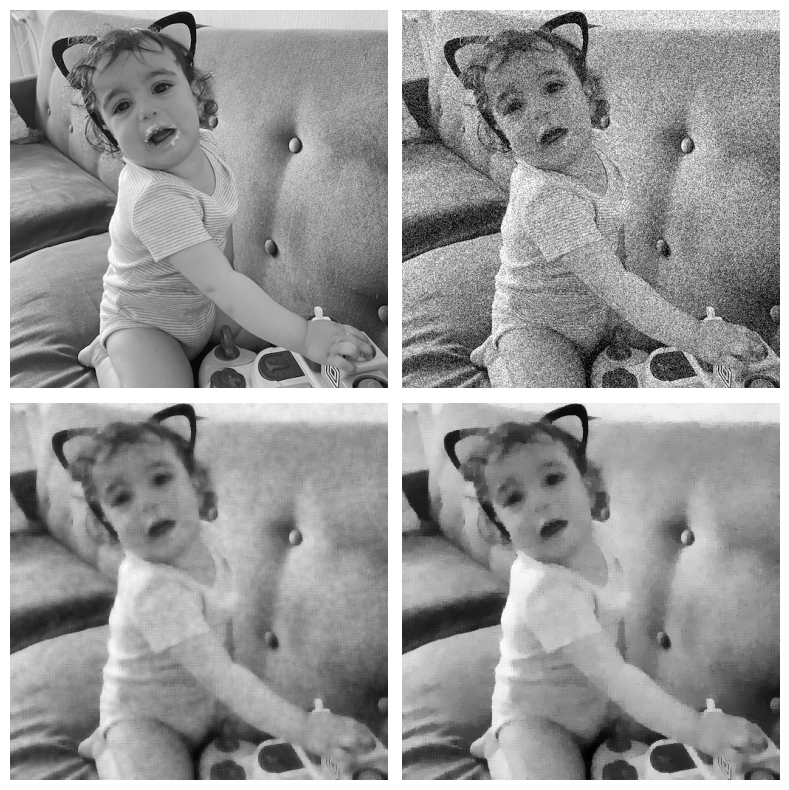

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs[0, 0].imshow(x, cmap="gray")
axs[0, 0].axis('off')
axs[0, 1].imshow(y, cmap="gray")
axs[0, 1].axis('off')
axs[1, 0].imshow(xinv_3.reshape(ny, nx), cmap="gray")
axs[1, 0].axis('off')
axs[1, 1].imshow(xinv_10.reshape(ny, nx), cmap="gray")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

In [7]:
iterations = [1, 2, 5, 10, 15, 20, 25]
errors = []
for iter in iterations:
    xinv, _, _ = pylops.optimization.sparsity.splitbregman(
        Op=Iop,
        y=y.ravel(),
        RegsL1=Dop,
        niter_outer=iter,
        niter_inner=1,
        mu=mu,
        epsRL1s=lamda,
        tol=5e-3,
        tau=1.0,
        restart=False,
    )
    errors.append(np.linalg.norm(xinv - x.ravel(), ord=1) / np.linalg.norm(x.ravel(), ord=1))

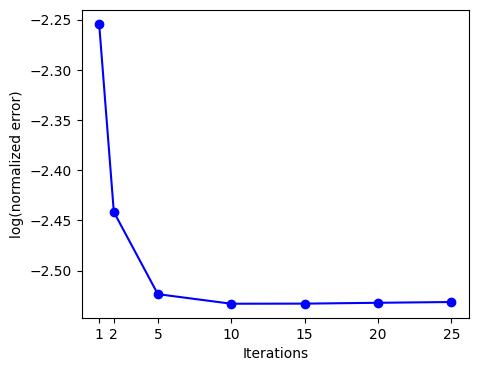

In [10]:
plt.figure(figsize=(5, 4))
plt.plot(iterations, np.log(errors), linestyle='-', marker='o', color='b')
plt.xticks(iterations)
plt.ylabel('log(normalized error)')
plt.xlabel('Iterations')
plt.show()

## CS Reconstruction

In [11]:
perc_subsampling = 0.6
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])
Rop = pylops.Restriction(ny * nx, iava, axis=0, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop * Fop * (x.ravel() + n.ravel())

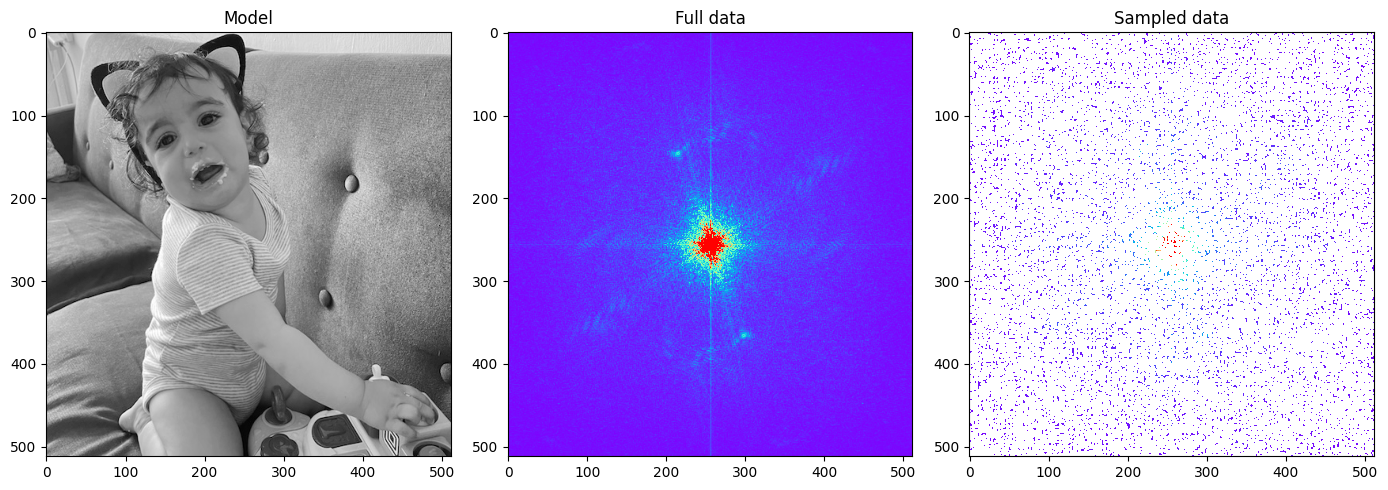

In [12]:
yfft = Fop * (x.ravel() + n.ravel())
yfft = np.fft.fftshift(yfft.reshape(ny, nx))
ymask = Rop.mask(Fop * (x.ravel()) + n.ravel())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight")
plt.tight_layout()
plt.show()

In [13]:
Dop = [
    pylops.FirstDerivative(
        dims=(ny, nx), axis=0, edge=False, kind="backward", dtype=np.complex128
    ),
    pylops.FirstDerivative(
        dims=(ny, nx), axis=1, edge=False, kind="backward", dtype=np.complex128
    ),
]

# CS
mu = 1.5
lamda = [0.1, 0.1]
niter = 2
niterinner = 2

xinv, _, cs_cost = pylops.optimization.sparsity.splitbregman(
    Op=Rop * Fop,
    RegsL1=Dop,
    y=y.ravel(),
    niter_outer=niter,
    niter_inner=niterinner,
    mu=mu,
    epsRL1s=lamda,
    tol=1e-4,
    tau=1.0,
)
xinv = np.real(xinv.reshape(ny, nx))

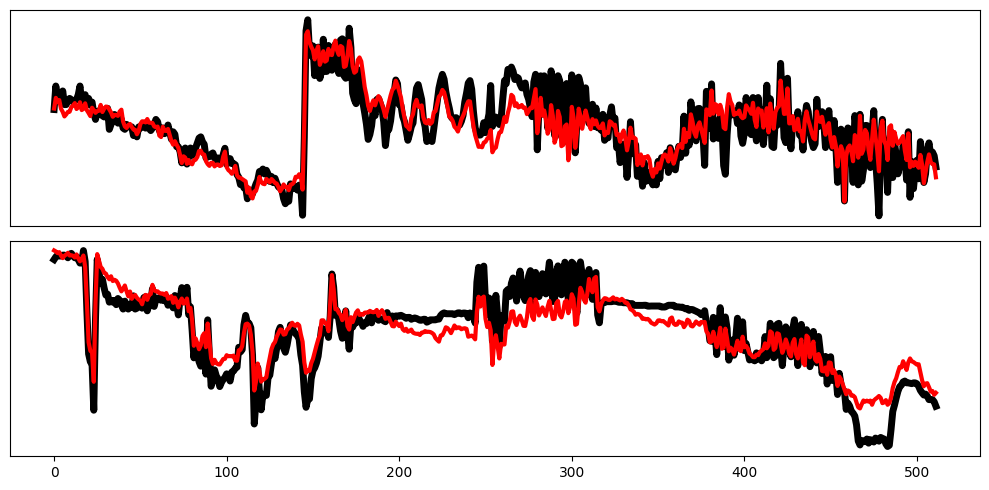

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(x[ny // 2] - x[ny // 2].mean(), "k", lw=5)
axs[0].plot(xinv[ny // 2] - xinv[ny // 2].mean(), "r", lw=3)
axs[0].yaxis.set_visible(False)
axs[0].xaxis.set_visible(False)
axs[1].plot(x[:, nx // 2] - x[:, nx // 2].mean(), "k", lw=5)
axs[1].plot(xinv[:, nx // 2] - xinv[:, nx // 2].mean(), "r", lw=3)
axs[1].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

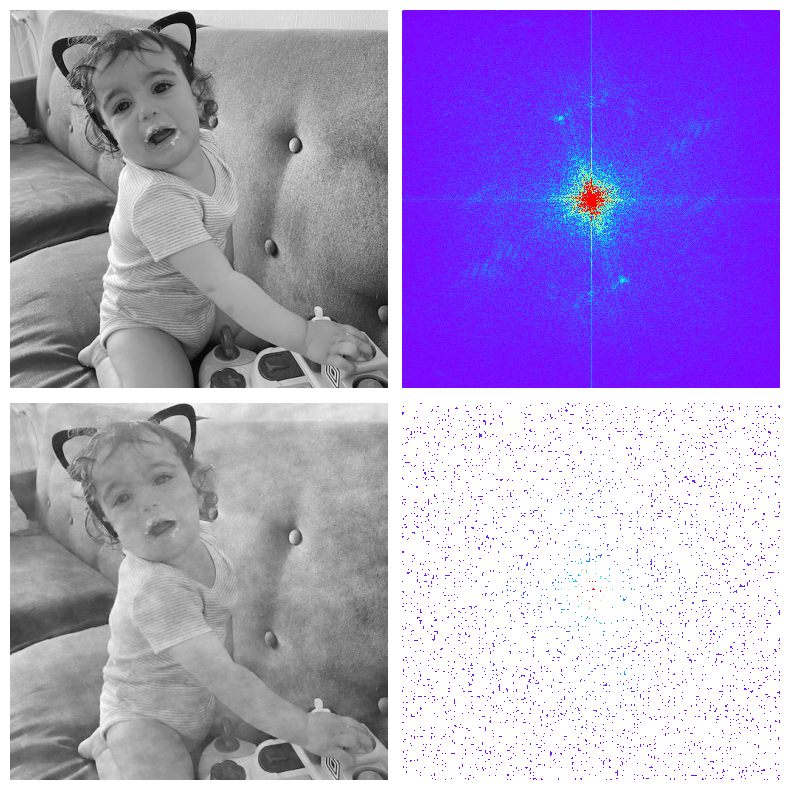

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs[0, 0].imshow(x, cmap="gray")
axs[0, 0].axis('off')
axs[0, 1].imshow(np.abs(yfft), norm='linear', interpolation='none', resample=False, vmin=0, vmax=1, cmap="rainbow")
axs[0, 1].axis('off')
axs[1, 0].imshow(np.real(xinv), cmap="gray")
axs[1, 0].axis('off')
axs[1, 1].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()